In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import chi2_contingency, ks_2samp, chisquare, poisson

In [ ]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
DRIVER_GENES = "../data/driver_genes"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/dir
MUT_COUNTS_PER_GENE = "../results/mutation_counts_per_gene.tsv"
RESULTS_DIR = "../results/PCAWG"
PLOT_DATA_DIR = "../plot_data/passenger_density"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types that have driver gene data
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.remove("Pancancer")
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [31]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [32]:
# genome-wide mutations
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
genome_wide_mutations["tissue_type"] = genome_wide_mutations["cancer_type"].apply(lambda x: x.split("-")[0])

In [33]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
	df["cancer_type"] = cancer_type
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	df = df[df["gene"].isin(driver_genes_list)]
	df = pd.merge(df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
	mut_df = pd.concat([mut_df, df])

print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/1447939191.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.

(90258, 15)
(82512, 15)


In [34]:
# passenger density for each gene in each sample
passenger_density = mut_df.groupby(["Tumor_Sample_Barcode", "gene"]).agg({
    "cancer_type": "first",
    "has_driver": "first",
    "driver": lambda x: x.value_counts().get(False, 0),
    "gene_length": "first",
    "mutation": "count"
}).reset_index()
passenger_density = passenger_density.rename(columns={"driver": "passenger_count", "mutation": "mutation_count"})
# adjust for genome-wide mutation rate, cna burden and gene length
print(passenger_density.shape, genome_wide_mutations.shape)
passenger_density = pd.merge(passenger_density, genome_wide_mutations, on=["cancer_type", "Tumor_Sample_Barcode"], how="left")
passenger_density["cna_burden"] = passenger_density["cna_burden"] / 100 # convert from percentage to fraction
print(passenger_density.shape)
# mutation rate = total mutations / genome size
# expected rate in gene = mutation rate * gene length
# adjusted mut (adjusting for genome-wide mutation rate) = mut / expected rate in gene = total mutations * genome size / (total mutations * gene length)
# adjusted mut (adjusting for cna burden) = adjusted mut / cna_burden = total mutations * genome size / (total mutations * gene length * cna_burden)
passenger_density["adj_passenger_density"] = passenger_density["passenger_count"] * 3.2e9 / (passenger_density["total_mutations"] * passenger_density["gene_length"] * passenger_density["cna_burden"])
passenger_density["organ"] = passenger_density["cancer_type"].apply(lambda x: x.split("-")[0])
passenger_density = passenger_density[["organ", "cancer_type", "Tumor_Sample_Barcode", "gene", "has_driver", "passenger_count", "adj_passenger_density", "mutation_count", "total_mutations", "cna_burden", "gene_length"]]

(9713, 7) (2778, 5)
(9713, 10)


In [35]:
# add rows for samples with no mutations in driver genes
tumors = passenger_density["Tumor_Sample_Barcode"].unique()
for tumor in tumors:
	cancer_type = passenger_density[passenger_density["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
	total_mutations = passenger_density[passenger_density["Tumor_Sample_Barcode"] == tumor]["total_mutations"].values[0]
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	for gene in driver_genes_list:
		if len(passenger_density[(passenger_density["Tumor_Sample_Barcode"] == tumor) & (passenger_density["gene"] == gene)]) == 0:
			passenger_density = pd.concat([passenger_density, pd.DataFrame({
				"cancer_type": [cancer_type],
				"Tumor_Sample_Barcode": [tumor], 
				"gene": [gene], 
				"has_driver": [False], 
				"adj_passenger_density": [0],
				"passenger_count": [0],
				"total_mutations": [total_mutations],
				"cna_burden": [0],
				"gene_length": [driver_genes[driver_genes["gene"] == gene]["gene_length"].values[0]],
				"mutation_count": [0],
			})])
passenger_density["organ"] = passenger_density["cancer_type"].apply(lambda x: x.split("-")[0])
print(passenger_density.shape)

(24625, 11)


In [36]:
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
print(cancer_gene_type.shape)
# cancer_gene_type = cancer_gene_type[cancer_gene_type["Hugo Symbol"].isin(driver_genes_list)]
# print(cancer_gene_type.shape)
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
passenger_density["cancer_gene_type"] = passenger_density["gene"].apply(lambda x: cancer_gene_type[cancer_gene_type["Hugo Symbol"] == x]["type"].values[0] if x in cancer_gene_type["Hugo Symbol"].tolist() else "Unknown")
print(passenger_density.shape)

(1154, 3)
(24625, 12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test smaller, P_val:2.165e-44 U_stat=2.901e+07


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/2404355339.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/2404355339.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


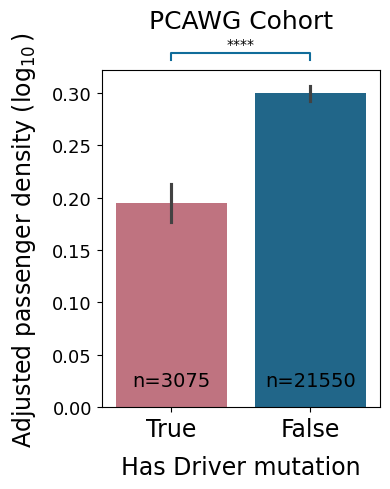

In [37]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))

plt.figure(figsize=(4, 5))
ax = sns.barplot(
    x="has_driver",
    y="passenger_density_log",
    data=passenger_density,
    order=[True, False],
    palette=cmap
)
# show number of data points
for i, has_driver in enumerate([True, False]):
    n = passenger_density[passenger_density["has_driver"] == has_driver].shape[0]
    plt.text(i, 0.02, f"n={n}", ha='center', fontsize=14, color='black')
    
# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=passenger_density, 
    x="has_driver",
    y="passenger_density_log", 
    pairs=[(True, False)],
    order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xlabel("Has Driver mutation", fontsize=17, labelpad=10)
plt.xticks(fontsize=17)
plt.yticks(fontsize=13)
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=17, labelpad=10)
plt.title("PCAWG Cohort", fontsize=18, pad=30)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_driver_status.png", dpi=300)

# source data
passenger_density[["has_driver", "adj_passenger_density"]].to_csv(f"{PLOT_DATA_DIR}/passenger_density_by_driver_status.tsv", sep="\t", index=False)


## Passenger density in TSG and OG

In [38]:
# compare passenger densities across all genes separately
from scipy.stats import mannwhitneyu
genes = passenger_density["gene"].unique().tolist()
genes.sort()
print(len(genes), genes)
gene_diff = []
for gene in genes:
    gene_type = cancer_gene_type[cancer_gene_type["Hugo Symbol"] == gene]["type"].values[0] if gene in cancer_gene_type["Hugo Symbol"].tolist() else "Unknown"
    selected_gene_df = passenger_density[passenger_density["gene"] == gene]
    group_with_drivers = selected_gene_df[selected_gene_df["has_driver"] == True]["adj_passenger_density"].dropna()
    group_without_drivers = selected_gene_df[selected_gene_df["has_driver"] == False]["adj_passenger_density"].dropna()
    # stat, p_value = mannwhitneyu(group_with_drivers, group_without_drivers, alternative='greater')
    # if p_value < 0.05:
    #     print(f"{gene} ({gene_type}): statistic = {stat}, p-value = {p_value}")
    # difference in passenger density
    diff = group_without_drivers.mean() - group_with_drivers.mean()
    gene_diff.append({
        "gene": gene,
        "gene_type": gene_type,
        "passenger_density_diff": diff,
        "n_with_drivers": group_with_drivers.shape[0],
        "n_without_drivers": group_without_drivers.shape[0],
    })
gene_diff_df = pd.DataFrame(gene_diff)
gene_diff_df = gene_diff_df.sort_values(by="passenger_density_diff", ascending=False)

138 ['AKAP9', 'AMER1', 'ANK1', 'APC', 'ARHGAP35', 'ARID1A', 'ARID1B', 'ARID2', 'ASXL2', 'ATM', 'ATRX', 'AXIN1', 'BCL2', 'BCOR', 'BIRC6', 'BRAF', 'BRCA1', 'BRCA2', 'BTG1', 'CARD11', 'CASP8', 'CBFB', 'CCND3', 'CDH1', 'CDH10', 'CDH11', 'CDK12', 'CDKN1A', 'CDKN2A', 'CHD4', 'CIC', 'COL1A1', 'CREBBP', 'CSMD3', 'CTNNB1', 'CYP2C8', 'DAXX', 'DDX3X', 'DNMT3A', 'EGFR', 'ELF3', 'EP300', 'ERBB2', 'ERCC2', 'EZH2', 'FAM135B', 'FAT1', 'FAT3', 'FAT4', 'FBXW7', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FOXA1', 'FUBP1', 'GATA3', 'GLI1', 'GNAS', 'IDH1', 'IL7R', 'IRF4', 'KDM5C', 'KDM6A', 'KEAP1', 'KIT', 'KMT2C', 'KMT2D', 'KRAS', 'LATS1', 'LDB1', 'LRP1B', 'MAP2K4', 'MAP3K1', 'MCM7', 'MDM2', 'MECOM', 'MED12', 'MEN1', 'MET', 'MGA', 'MTOR', 'MYC', 'MYD88', 'NACA', 'NBEA', 'NF1', 'NFE2L2', 'NFKBIE', 'NOTCH1', 'NOTCH2', 'NRAS', 'NSD1', 'NXF1', 'P2RY8', 'PALB2', 'PBRM1', 'PIK3CA', 'PIK3R1', 'PIM1', 'PPP2R1A', 'PREX2', 'PRKAR1A', 'PTCH1', 'PTEN', 'PTPN11', 'PTPRD', 'PTPRT', 'RANBP2', 'RB1', 'RBM10', 'RELA', 'RGS7', 'RO

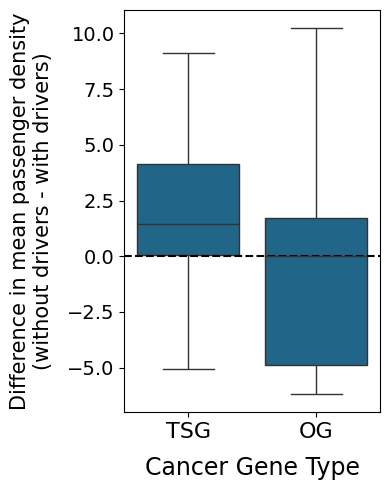

In [39]:
plt.figure(figsize=(4, 5))
sns.boxplot(
    x="gene_type",
    y="passenger_density_diff",
    data=gene_diff_df[gene_diff_df["gene_type"].isin(["OG", "TSG"])],
    showfliers=False,
    order=["TSG", "OG"],
    color=cmap[1]
)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Cancer Gene Type", fontsize=17, labelpad=10)
plt.ylabel("Difference in mean passenger density\n(without drivers - with drivers)", fontsize=15, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_density_difference_by_gene_type.png", dpi=300)

# source data
gene_diff_df[["gene", "gene_type", "passenger_density_diff"]].to_csv(f"{PLOT_DATA_DIR}/passenger_density_difference_by_gene_type.tsv", sep="\t", index=False)

## Passenger density by cancer and tissue type

In [40]:
passenger_density_by_tissue = passenger_density.groupby(["organ", "has_driver"]).agg({
	"adj_passenger_density": "mean",
}).reset_index()
passenger_density_by_tissue = passenger_density_by_tissue.pivot(index="organ", columns="has_driver", values="adj_passenger_density")
passenger_density_by_tissue["diff"] = passenger_density_by_tissue[False] - passenger_density_by_tissue[True]
passenger_density_by_tissue["ratio"] = passenger_density_by_tissue[False] / passenger_density_by_tissue[True]
passenger_density_by_tissue.sort_values("ratio", ascending=False, inplace=True)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/3942221471.py:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax1 = sns.boxplot(


[(('Biliary', True), ('Biliary', False)), (('Bladder', True), ('Bladder', False)), (('Bone', True), ('Bone', False)), (('Breast', True), ('Breast', False)), (('CNS', True), ('CNS', False)), (('Cervix', True), ('Cervix', False)), (('ColoRect', True), ('ColoRect', False)), (('Eso', True), ('Eso', False)), (('Head', True), ('Head', False)), (('Kidney', True), ('Kidney', False)), (('Liver', True), ('Liver', False)), (('Lung', True), ('Lung', False)), (('Lymph', True), ('Lymph', False)), (('Myeloid', True), ('Myeloid', False)), (('Ovary', True), ('Ovary', False)), (('Panc', True), ('Panc', False)), (('Prost', True), ('Prost', False)), (('Skin', True), ('Skin', False)), (('Stomach', True), ('Stomach', False)), (('Thy', True), ('Thy', False)), (('Uterus', True), ('Uterus', False))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation leg

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/3942221471.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/3942221471.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=90, fontsize=17)


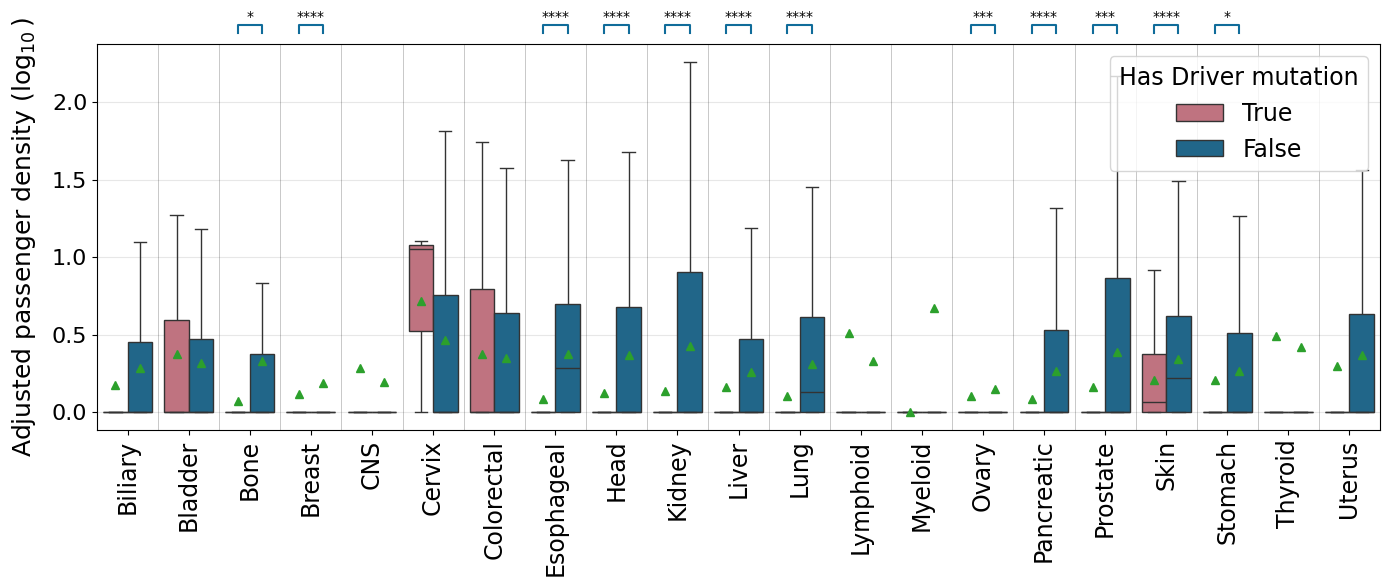

In [41]:
# distribution of passenger mutation density by cancer type
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
cancers = passenger_density["organ"].unique().tolist()
cancers.sort()
plt.figure(figsize=(14, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="organ",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["organ"] == cancer]
    if len(cancer_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="organ", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

# labels with full cancer name
labels = cancers[:]
labels[6] = "Colorectal"
labels[7] = "Esophageal"
labels[12] = "Lymphoid"
labels[15] = "Pancreatic"
labels[16] = "Prostate"
labels[19] = "Thyroid"
ax1.set_xticklabels(labels, rotation=90, fontsize=17)

plt.xlabel("")
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=18, labelpad=10)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.legend(title="Has Driver mutation", title_fontsize=17, fontsize=17, loc='upper right')
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_cancer_type.png", dpi=300)

# source data
passenger_density[["organ", "has_driver", "adj_passenger_density"]].to_csv(f"{PLOT_DATA_DIR}/passenger_density_by_cancer_type.tsv", sep="\t", index=False)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/911111882.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax1 = sns.boxplot(


[(('Biliary-AdenoCA', True), ('Biliary-AdenoCA', False)), (('Bladder-TCC', True), ('Bladder-TCC', False)), (('Bone-Leiomyo', True), ('Bone-Leiomyo', False)), (('Bone-Osteosarc', True), ('Bone-Osteosarc', False)), (('Breast-AdenoCa', True), ('Breast-AdenoCa', False)), (('Breast-LobularCa', True), ('Breast-LobularCa', False)), (('CNS-GBM', True), ('CNS-GBM', False)), (('CNS-Medullo', True), ('CNS-Medullo', False)), (('CNS-Oligo', True), ('CNS-Oligo', False)), (('CNS-PiloAstro', True), ('CNS-PiloAstro', False)), (('Cervix-SCC', True), ('Cervix-SCC', False)), (('ColoRect-AdenoCA', True), ('ColoRect-AdenoCA', False)), (('Eso-AdenoCa', True), ('Eso-AdenoCa', False)), (('Head-SCC', True), ('Head-SCC', False)), (('Kidney-ChRCC', True), ('Kidney-ChRCC', False)), (('Kidney-RCC', True), ('Kidney-RCC', False)), (('Liver-HCC', True), ('Liver-HCC', False)), (('Lung-AdenoCA', True), ('Lung-AdenoCA', False)), (('Lung-SCC', True), ('Lung-SCC', False)), (('Lymph-BNHL', True), ('Lymph-BNHL', False)), (('

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/911111882.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])


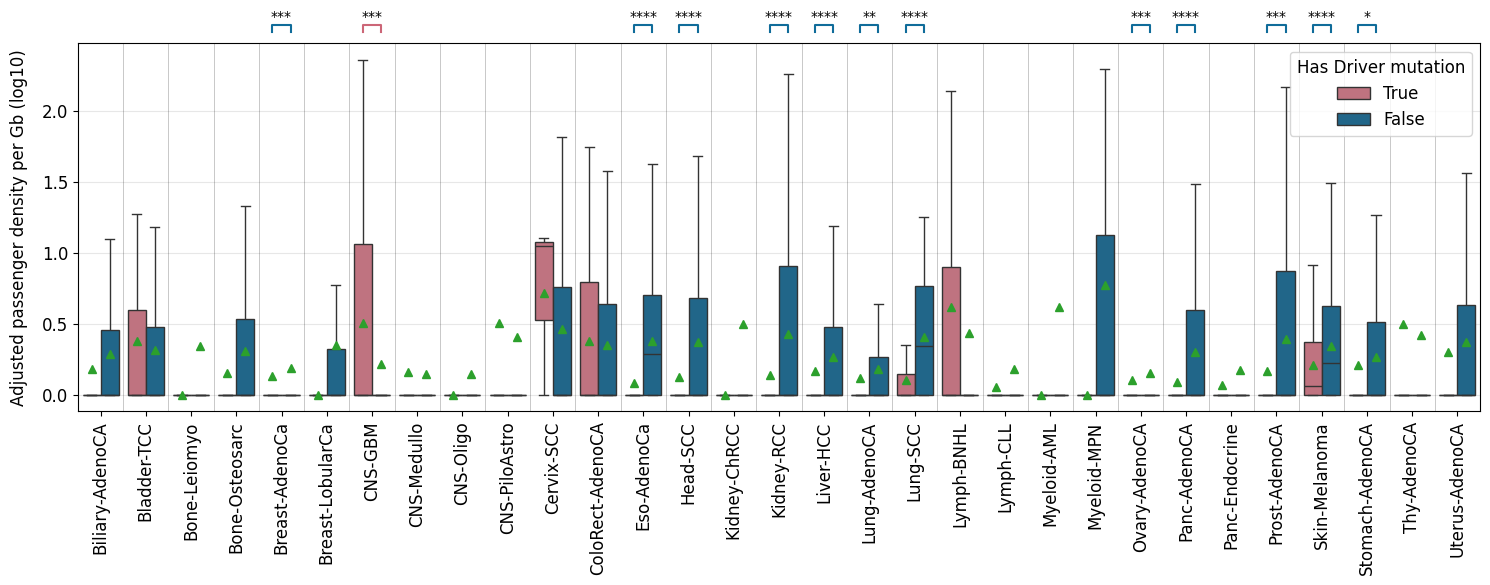

In [42]:
# distribution of passenger mutation density by cancer type
cancers = passenger_density["cancer_type"].unique().tolist()
cancers.sort()
plt.figure(figsize=(15, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="cancer_type",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["cancer_type"] == cancer]
    if len(cancer_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="cancer_type", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

plt.xticks(rotation=90, fontsize=12)
plt.xlabel("")
plt.ylabel("Adjusted passenger density per Gb (log10)", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.legend(title="Has Driver mutation", title_fontsize=12, fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_cancer_subtype.png", dpi=300)

# source data
passenger_density[["cancer_type", "has_driver", "adj_passenger_density"]].to_csv(f"{PLOT_DATA_DIR}/passenger_density_by_cancer_subtype.tsv", sep="\t", index=False)

## Gene length and mutation count statistics

In [43]:
passenger_counts_all = passenger_density.copy()
passenger_counts_all = passenger_counts_all[["Tumor_Sample_Barcode", "gene", "gene_length", "has_driver", "passenger_count"]]
passenger_counts_all["passenger_count_bin"] = pd.cut(passenger_counts_all["passenger_count"], bins=[-1,0,1,2,3,4,5,10,20,np.inf], labels=["0","1","2","3","4","5","6-10","11-20","20+"])
passenger_counts_all = passenger_counts_all.groupby("passenger_count_bin").agg({
    "Tumor_Sample_Barcode": "nunique",
    "gene": "nunique",
    "gene_length": lambda x: ', '.join([str(int(x.min())), str(float(x.mean())), str(int(x.max()))])  
}).reset_index().rename(columns={
    "Tumor_Sample_Barcode": "num_unique_samples",
    "gene": "num_unique_genes",
    "gene_length": "gene_length_stats (min/avg/max)"
})
passenger_counts_all.to_csv(MUT_COUNTS_PER_GENE, sep="\t", index=False)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_904/2449598253.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  passenger_counts_all = passenger_counts_all.groupby("passenger_count_bin").agg({


## Difference in observed and expected frequencies of passenger mutations

In [44]:
upper_limit = 10
passenger_counts = passenger_density[["has_driver", "passenger_count"]].copy()
passenger_counts = passenger_counts[passenger_counts["passenger_count"] <= upper_limit]

In [45]:
# chi-square test
observed = pd.crosstab(
    passenger_counts["has_driver"],
    passenger_counts["passenger_count"],
)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")

p-value: 1.74972222755973e-28, stat: 156.45002342870174


In [46]:
expected_df = pd.DataFrame(expected, columns=observed.columns, index=observed.index)
expected_df = expected_df.rename_axis(index=None, columns=None)
observed_df = pd.DataFrame(observed, columns=observed.columns, index=observed.index)
observed_df = observed_df.rename_axis(index=None, columns=None)

# get the difference between observed and expected for corresponding cells
residuals = observed_df - expected_df

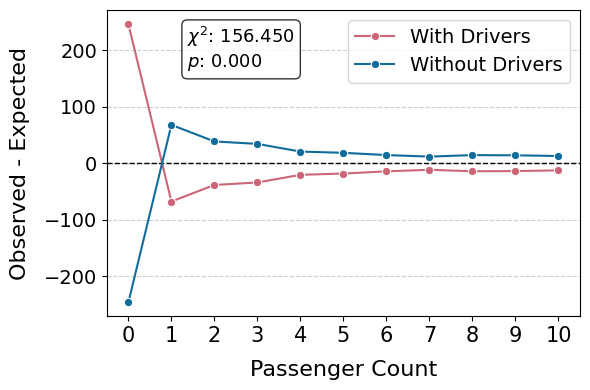

In [47]:
plt.figure(figsize=(6, 4))

# horizontal line at y=0
plt.axhline(0, color='black', lw=1, ls='--')

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[True],
	color=colors[0],
	label="With Drivers",
	marker="o",
)

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[False],
	color=colors[1],
	label="Without Drivers",
	marker="o",
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.ylabel("Observed - Expected", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_count_chi_square_residuals.png", dpi=300)

# source data
residuals.reset_index().to_csv(f"{PLOT_DATA_DIR}/passenger_count_chi_square_residuals.tsv", sep="\t", index=False)

## Frequencies for the 2 groups

In [48]:
upper_limit = 10
passenger_counts = passenger_density[["has_driver", "passenger_count"]].copy()
passenger_counts = passenger_counts[(passenger_counts["passenger_count"] <= upper_limit)]
observed_with_driver = pd.DataFrame()
observed_without_driver = pd.DataFrame()
residuals = pd.DataFrame()
for _ in range(10000):  # repeated sampling with replacement
	observed_with_driver_sampled = passenger_counts[passenger_counts["has_driver"] == True].sample(frac=1, replace=True).reset_index(drop=True)
	observed_with_driver_freq = observed_with_driver_sampled["passenger_count"].value_counts().sort_index().reset_index()
	observed_with_driver_freq = observed_with_driver_freq.rename(columns={"passenger_count": "num_passengers", "count": "frequency"})
	observed_with_driver = pd.concat([observed_with_driver, observed_with_driver_freq], ignore_index=True)
	
	observed_without_driver_sampled = passenger_counts[passenger_counts["has_driver"] == False].sample(frac=1, replace=True).reset_index(drop=True)
	observed_without_driver_freq = observed_without_driver_sampled["passenger_count"].value_counts().sort_index().reset_index()
	observed_without_driver_freq = observed_without_driver_freq.rename(columns={"passenger_count": "num_passengers", "count": "frequency"})
	observed_without_driver = pd.concat([observed_without_driver, observed_without_driver_freq], ignore_index=True)

observed_with_driver["frequency"] = np.log10(observed_with_driver["frequency"] + 1)	
observed_without_driver["frequency"] = np.log10(observed_without_driver["frequency"] + 1)

# get error bars for mean
std = observed_with_driver.groupby("num_passengers")["frequency"].std().reset_index()
std = std.rename(columns={"frequency": "std"})
observed_with_driver_mean = observed_with_driver.groupby("num_passengers")["frequency"].mean().reset_index()
observed_with_driver_mean = observed_with_driver_mean.rename(columns={"frequency": "mean"})
observed_with_driver_mean = pd.merge(observed_with_driver_mean, std, on="num_passengers", how="left")
observed_with_driver_mean["upper_limit"] = observed_with_driver_mean["mean"] + observed_with_driver_mean["std"]
observed_with_driver_mean["lower_limit"] = observed_with_driver_mean["mean"] - observed_with_driver_mean["std"]

std = observed_without_driver.groupby("num_passengers")["frequency"].std().reset_index()
std = std.rename(columns={"frequency": "std"})
observed_without_driver_mean = observed_without_driver.groupby("num_passengers")["frequency"].mean().reset_index()
observed_without_driver_mean = observed_without_driver_mean.rename(columns={"frequency": "mean"})	
observed_without_driver_mean = pd.merge(observed_without_driver_mean, std, on="num_passengers", how="left")
observed_without_driver_mean["upper_limit"] = observed_without_driver_mean["mean"] + observed_without_driver_mean["std"]
observed_without_driver_mean["lower_limit"] = observed_without_driver_mean["mean"] - observed_without_driver_mean["std"]

In [49]:
# Chi-Squared Test for Homogeneity
observed = pd.crosstab(
    observed_with_driver["num_passengers"], 
    observed_without_driver["num_passengers"]
)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")

p-value: 1.69208104773514e-27, stat: 337.38839267905047


In [50]:
patients_with_drivers = passenger_counts[passenger_counts["has_driver"] == True].count().values[0]
patients_without_drivers = passenger_counts[passenger_counts["has_driver"] == False].count().values[0]

print(f"Patients with drivers: {patients_with_drivers}, Patients without drivers: {patients_without_drivers}")

Patients with drivers: 3031, Patients without drivers: 20259


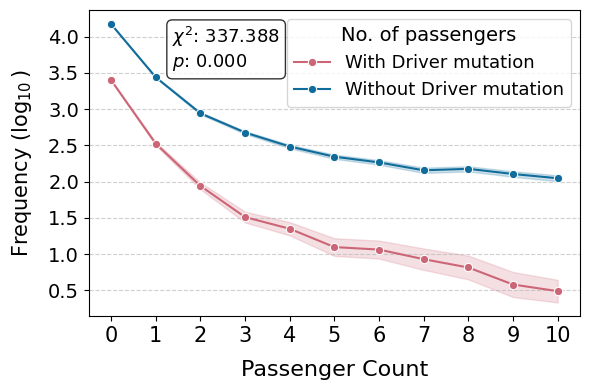

In [51]:
plt.figure(figsize=(6, 4))
sns.lineplot(
	data=observed_with_driver_mean,
	x="num_passengers",
	y="mean",
	color=colors[0],
	label="With Driver mutation",
	marker="o",
)

sns.lineplot(
	data=observed_without_driver_mean,
	x="num_passengers",
	y="mean",
	color=colors[1],
	label="Without Driver mutation",
	marker="o",
)

plt.fill_between(
	x=observed_with_driver_mean["num_passengers"],
	y1=observed_with_driver_mean["upper_limit"],
	y2=observed_with_driver_mean["lower_limit"],
	alpha=0.2,
	color=colors[0]
)

plt.fill_between(
	x=observed_without_driver_mean["num_passengers"],
	y1=observed_without_driver_mean["upper_limit"],
	y2=observed_without_driver_mean["lower_limit"],
	alpha=0.2,
	color=colors[1]
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.ylabel(r"Frequency ($\log_{10}$)", fontsize=15, labelpad=10)
plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="No. of passengers", title_fontsize=14, fontsize=13)
plt.tight_layout()

In [52]:
# Test: frequency of co-occurring (2nd+) vs solo passenger mutations
# For each sample-gene pair with passengers, count how many have exactly 1 vs 2+ passengers

co_occurrence_data = passenger_density[passenger_density["passenger_count"] > 0].copy()
co_occurrence_data["is_co_occurrent"] = co_occurrence_data["passenger_count"] > 1

# Overall comparison
solo_count = (co_occurrence_data["is_co_occurrent"] == False).sum()
co_occurrent_count = (co_occurrence_data["is_co_occurrent"] == True).sum()
total_with_passengers = len(co_occurrence_data)

print(f"Sample-gene pairs WITH passenger mutations:")
print(f"Solo (exactly 1 passenger): {solo_count} ({100*solo_count/total_with_passengers:.1f}%)")
print(f"Co-occurring (2+ passengers): {co_occurrent_count} ({100*co_occurrent_count/total_with_passengers:.1f}%)")
print(f"Total: {total_with_passengers}")

Sample-gene pairs WITH passenger mutations:
Solo (exactly 1 passenger): 3087 (42.9%)
Co-occurring (2+ passengers): 4112 (57.1%)
Total: 7199


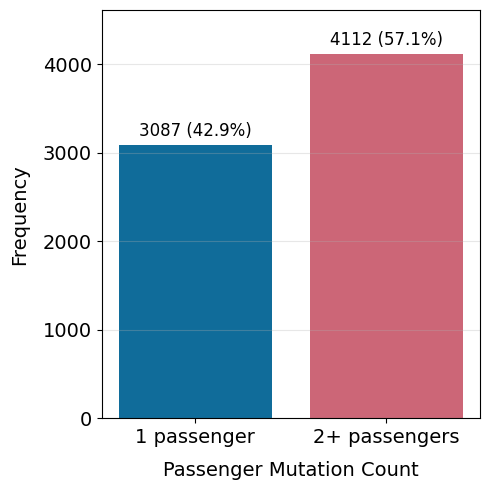

In [53]:
# Plot 1: Overall counts
plt.figure(figsize=(5, 5))
recurrence_summary = co_occurrence_data["is_co_occurrent"].value_counts().sort_index()
recurrence_labels = ["1 passenger", "2+ passengers"]
colors = ["#CC6677", "#106C9A", "#529267"]
colors_rec = [colors[1], colors[0]]
ax1 = plt.bar(recurrence_labels, [recurrence_summary[False], recurrence_summary[True]], color=colors_rec)
plt.xlabel("Passenger Mutation Count", fontsize=14, labelpad=10)
plt.ylabel("Frequency", fontsize=14, labelpad=10)
plt.ylim(0, recurrence_summary.max() + 500)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate([recurrence_summary[False], recurrence_summary[True]]):
    pct = 100 * v / total_with_passengers
    plt.text(i, v + 100, f"{int(v)} ({pct:.1f}%)", ha='center', fontsize=12)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_mutation_co-occurrence_overall.png", dpi=300)

# source data
recurrence_summary_df = pd.DataFrame({
    "passenger_count_category": recurrence_labels,
    "frequency": [recurrence_summary[False], recurrence_summary[True]]
})
recurrence_summary_df.to_csv(f"{PLOT_DATA_DIR}/passenger_mutation_co-occurrence_overall.tsv", sep="\t", index=False)

## Examining relation between no. of drivers and passengers in a gene

In [54]:
passenger_driver_counts = mut_df.groupby(["Tumor_Sample_Barcode", "gene"]).agg({
    "driver": lambda x: x.value_counts().get(True, 0),
}).reset_index()
print(passenger_driver_counts.shape)
passenger_driver_counts = pd.merge(passenger_driver_counts, passenger_density[["Tumor_Sample_Barcode", "gene", "adj_passenger_density", "passenger_count"]], on=["Tumor_Sample_Barcode", "gene"], how="left")
passenger_driver_counts["driver_count_bin"] = pd.cut(passenger_driver_counts["driver"], bins=[-np.inf, 0, 1, 2, np.inf], labels=["0", "1", "2", "3+"])
passenger_driver_counts["log_passenger_density"] = np.log1p(passenger_driver_counts["adj_passenger_density"] + 1)
print(passenger_driver_counts.shape)

(9713, 3)
(9713, 7)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.722e+07
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.233e-08 U_stat=2.643e+05
2 vs. 3+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.137e-05 U_stat=1.114e+03
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.088e-68 U_stat=1.227e+06
1 vs. 3+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.140e-11 U_stat=1.196e+04


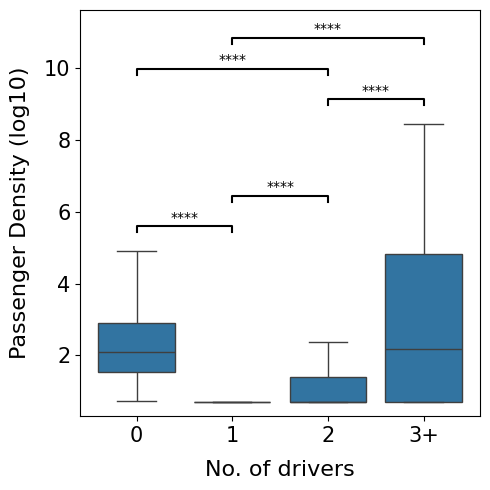

In [55]:
plt.figure(figsize=(5, 5))
sns.boxplot(
    data=passenger_driver_counts,
    x="driver_count_bin",
    y="log_passenger_density",
    showfliers=False
)

box_pairs = [
    ("0", "1"),
    ("0", "2"),
    ("0", "3+"),
    ("1", "2"),
    ("1", "3+"),
    ("2", "3+"),
]
annotator = Annotator(
    plt.gca(), 
    data=passenger_driver_counts, 
    x="driver_count_bin",
    y="log_passenger_density", 
    pairs=box_pairs,
    order=["0", "1", "2", "3+"]
)
annotator.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, color='black')
annotator.apply_and_annotate()

plt.xlabel("No. of drivers", fontsize=16, labelpad=10)
plt.ylabel("Passenger Density (log10)", fontsize=16, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_driver_count.png", dpi=300)

# source data
passenger_driver_counts[["driver_count_bin", "adj_passenger_density"]].to_csv(f"{PLOT_DATA_DIR}/passenger_density_by_driver_count.tsv", sep="\t", index=False)